In [1]:
from glob import glob
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import pandas as pd
from scipy.sparse import csr_array
from functools import reduce

import config
import sys
sys.path.append("../")

from sklearn.metrics import ndcg_score
from detect import detect_singlebatch, detect_multibatch, _get_altered_in_window
from utils import get_support_bucket

from distill import Result

exp_type = "adult"
if exp_type == "adult":
    noise = 0.5
    checkpoint = "xgb-adult"
    ckpt_dir = "/data2/fgiobergia/drift-experiments/"
else:
    ckpt_dir = os.path.join(config.ckpt_dir, "sup-wise")
    noise = 1.0
    checkpoint = "resnet50"
fnames = glob(os.path.join(ckpt_dir, f"{checkpoint}-noise-{noise:.2f}*pkl"))
supports = [ get_support_bucket(fname) for fname in fnames ]

df_names = pd.DataFrame({ "filename": fnames, "from_sup": [a for a,b in supports], "to_sup": [b for a,b in supports] })

In [2]:
def get_corr(a, b):
    if (a == a[0]).all() or (b == b[0]).all():
        return 0
    return np.corrcoef(a, b)[0,1]


def get_file_info(fname, window=5):
    with open(fname, "rb") as f:
        res = pickle.load(f)
        matches_ts_list = res["matches_batches"]
        altered = res["altered"]
        divs = res["divs"]

    for d in divs:
        d.set_index("subgroup", inplace=True)
        d["accuracy"] = (d["tp"] + d["tn"]) / (d["tp"] + d["tn"] + d["fp"] + d["fn"])
        # d["f1"] = 2 * d["tp"] / (2 * d["tp"] + d["fp"] + d["fn"])

    ndx = divs[0].index
    
    vals_delta = []
    vals_tstat = []
    vals_altered = []

    altered_per_sg = np.vstack([ matches_ts_list[i].matches[altered[i]].sum(axis=0) for i in range(len(matches_ts_list)) ])
    count_per_sg =   np.vstack([ matches_ts_list[i].matches.sum(axis=0) for i in range(len(matches_ts_list)) ])
    count_per_sg[count_per_sg == 0] = 1 # avoid division by 0 (fraction will still be 0)
    altered_frac = altered_per_sg / count_per_sg

    for start_curr in range(window, len(matches_ts_list)-window):
        altered2 = _get_altered_in_window(matches_ts_list, altered_frac, (start_curr, window))
        delta, t_stat = detect_singlebatch(divs, "accuracy", (0, window), (start_curr, window))

        delta_values = delta.values
        tstat_values = t_stat.values

        delta_values[np.isnan(delta_values)] = 0
        tstat_values[np.isnan(tstat_values)] = 0

        vals_delta.append(delta_values.min())
        vals_tstat.append(tstat_values.max())
        vals_altered.append(altered2.max())
    
    return vals_delta, vals_tstat, vals_altered

In [3]:
N = 25

deltas = []
tstats = []
altered = []
for fname in tqdm(df_names[df_names.from_sup == 0.1129].sample(n=N).filename):
    delta, tstat, alt = get_file_info(fname)
    deltas.append(np.array(delta))
    tstats.append(np.array(tstat))
    altered.append(np.array(alt))


100%|██████████| 25/25 [06:21<00:00, 15.27s/it]


In [4]:
deltas = np.vstack(deltas)
tstats = np.vstack(tstats)
altered = np.vstack(altered)

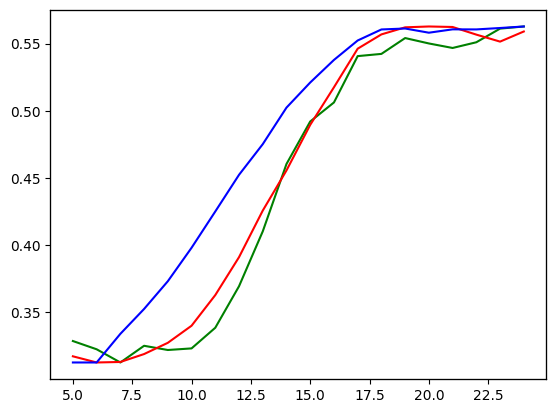

In [7]:
window = 5
n_batches = 30
fig, ax = plt.subplots()
ax.plot(range(window, n_batches-window), -deltas.mean(axis=0), c='g')

ax2 = ax.twinx()
ax2.plot(range(window, n_batches-window), tstats.mean(axis=0), c='r')
# ax2.xlim(0, n_batches)
# ax.set_xlim(0, n_batches)
ax2.yaxis.set_visible(False)

ax3 = ax.twinx()
# ax3.errorbar(range(window, n_batches-window), altered.mean(axis=0), yerr=altered.std(axis=0), c='b')
ax3.plot(range(window, n_batches-window), altered.mean(axis=0), c='b')
ax3.yaxis.set_visible(False)

# ax4 = ax.twinx()
# ax4.plot(range(0, n_batches)[:-5], noise_fracs[5:], c='k', ls='--')
# ax4.yaxis.set_visible(False)


In [8]:

def multicolor_ylabel(ax,list_of_strings,list_of_colors,axis='x',anchorpad=0,**kw):
    """this function creates axes labels with multiple colors
    ax specifies the axes object where the labels should be drawn
    list_of_strings is a list of all of the text items
    list_if_colors is a corresponding list of colors for the strings
    axis='x', 'y', or 'both' and specifies which label(s) should be drawn"""
    from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

    # x-axis label
    if axis=='x' or axis=='both':
        boxes = [TextArea(text, textprops=dict(color=color, ha='left',va='bottom',**kw)) 
                    for text,color in zip(list_of_strings,list_of_colors) ]
        xbox = HPacker(children=boxes,align="center",pad=0, sep=5)
        anchored_xbox = AnchoredOffsetbox(loc=3, child=xbox, pad=anchorpad,frameon=False,bbox_to_anchor=(0.2, -0.09),
                                          bbox_transform=ax.transAxes, borderpad=0.)
        ax.add_artist(anchored_xbox)

    # y-axis label
    if axis=='y' or axis=='both':
        boxes = [TextArea(text, textprops=dict(color=color, ha='left',va='bottom',rotation=90,**kw)) 
                     for text,color in zip(list_of_strings,list_of_colors) ]
        ybox = VPacker(children=boxes,align="center", pad=0, sep=5)
        anchored_ybox = AnchoredOffsetbox(loc=3, child=ybox, pad=anchorpad, frameon=False, bbox_to_anchor=(-0.075, 0.2), 
                                          bbox_transform=ax.transAxes, borderpad=0.)
        ax.add_artist(anchored_ybox)


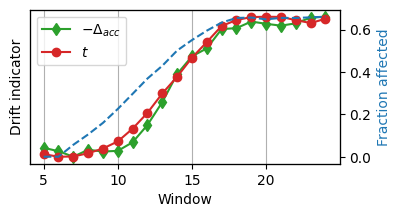

In [60]:
fig, ax = plt.subplots(figsize=(4,2))
ax.plot(range(window, n_batches-window), -deltas.mean(axis=0), c='tab:green', label=r"$-\Delta_{acc}$", marker='d', zorder=1)

ax2 = ax.twinx()
ax2.plot(range(window, n_batches-window), tstats.mean(axis=0), c='tab:red', label="$t$", marker='o', zorder=1)
# ax2.xlim(0, n_batches)
# ax.set_xlim(0, n_batches)
ax2.yaxis.set_visible(False)

ax3 = ax.twinx()
ax3.plot(range(window, n_batches-window), altered.mean(axis=0), c='tab:blue', ls='--', zorder=1)
ax3.set_ylabel("Fraction affected", color='tab:blue')
ax.set_xlabel("Window")
ax.set_ylabel("Drift indicator")

# multicolor_ylabel(ax, [r"$-\Delta_{perf}$", "/", "$t$"], ["g", "k", "r"], axis='y')#, anchorpad=0.5)#, size=15)
# ax.set_ylabel("x")

# ax4 = ax.twinx()
# ax4.plot(range(0, n_batches)[:-5], noise_fracs[5:], c='k', ls='--')
# ax4.yaxis.set_visible(False)

# include ax2's legend in ax
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
legend = ax.legend(lines + lines2, labels + labels2, loc=0)
legend.set_zorder(2)


# z to the back
ax.xaxis.grid(zorder=0)
# ax3.grid(zorder=0)

ax.set_axisbelow(True)
ax3.set_axisbelow(True)
ax2.set_axisbelow(True)
ax.set_yticks([])

fig.savefig("transitory.pdf", bbox_inches='tight')

In [61]:
N = 25

deltas = {}
tstats = {}
altered = {}
for window in range(2, 11):
    deltas[window] = []
    tstats[window] = []
    altered[window] = []

    for fname in tqdm(df_names[df_names.from_sup == 0.1129].sample(n=N).filename):
        delta, tstat, alt = get_file_info(fname, window=window)
        deltas[window].append(np.array(delta))
        tstats[window].append(np.array(tstat))
        altered[window].append(np.array(alt))

100%|██████████| 25/25 [03:34<00:00,  8.58s/it]


In [98]:
mat_tstat = np.full((9, 30), np.nan)
for window in range(2, 11):
    mat_tstat[window-2, window + window:] = np.vstack(tstats[window]).mean(axis=0)

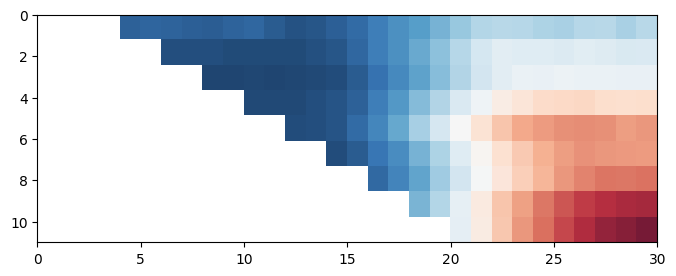

In [101]:
import matplotlib.pyplot as plt

max_win_size = 10

fig, ax = plt.subplots(figsize=(8, 4))
# include legend for colors
m = ax.imshow(mat_tstat, zorder=2, extent=[0, 30, max_win_size+1, 0], cmap='RdBu_r', alpha=.9)
# ax.set_xticks(range(30))
# ax.set_yticks(range(max_win_size+1))
# # shift all ticks 0.5 right
# ax.set_xticklabels([ str(i) if i % 5 == 0 else "" for i in range(30) ])



# for ws in range(2, max_win_size+1):
#     # draw rectangle of size win_size on the left
#     # black borders
#     ax.add_patch(plt.Rectangle((0, ws), ws, 1, color='g', alpha=.2, zorder=1))


# ax.set_xlabel("Batch")
# ax.set_ylabel("Window size")
# ax.grid()
# ax.axvline(11, c='#f0f', zorder=3)
# ax.set_xlim([0, 30-1])
# ax.set_ylim([max_win_size+1, 2])
# fig.colorbar(m, shrink=0.5, orientation="horizontal",  ax=ax, label=f"Top-{topn} accuracy", location="top")
# fig.savefig("ttest-corr.pdf", bbox_inches="tight")